In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Activation, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
#from keras.utils import  array_to_img, img_to_array, load_img
from keras.preprocessing.image import ImageDataGenerator
import os
import gdown
from zipfile import ZipFile

In [ ]:
os.makedirs("celeba_gan")

url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
output = "celeba_gan/data.zip"
gdown.download(url, output, quiet=True)

with ZipFile("celeba_gan/data.zip", "r") as zipobj:
    zipobj.extractall("celeba_gan")


FileExistsError: ignored

In [ ]:
atributes = pd.read_csv('list_attr_celeba.csv')
atributes.set_index('image_id', inplace=True)
atributes.replace(to_replace=-1, value=0, inplace=True) 
atributes.head()

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
image_id,,,,,,,,,,,,,,,,,,,,,
000001.jpg,0,1,1,0,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
000002.jpg,0,0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
000003.jpg,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
000004.jpg,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,1,1,0,1
000005.jpg,0,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1


In [ ]:
for i, j in enumerate(atributes.columns):
    print(i, j)

0 5_o_Clock_Shadow
1 Arched_Eyebrows
2 Attractive
3 Bags_Under_Eyes
4 Bald
5 Bangs
6 Big_Lips
7 Big_Nose
8 Black_Hair
9 Blond_Hair
10 Blurry
11 Brown_Hair
12 Bushy_Eyebrows
13 Chubby
14 Double_Chin
15 Eyeglasses
16 Goatee
17 Gray_Hair
18 Heavy_Makeup
19 High_Cheekbones
20 Male
21 Mouth_Slightly_Open
22 Mustache
23 Narrow_Eyes
24 No_Beard
25 Oval_Face
26 Pale_Skin
27 Pointy_Nose
28 Receding_Hairline
29 Rosy_Cheeks
30 Sideburns
31 Smiling
32 Straight_Hair
33 Wavy_Hair
34 Wearing_Earrings
35 Wearing_Hat
36 Wearing_Lipstick
37 Wearing_Necklace
38 Wearing_Necktie
39 Young


Male          0
Young         1
Eyeglasses    0
Name: 000167.jpg, dtype: int64

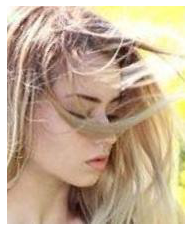

In [ ]:
images_folder = '/content/celeba_gan/img_align_celeba/'
ej = images_folder + '000167.jpg'
img = load_img(ej)
plt.grid(False)
plt.imshow(img)
plt.axis('off')
atributes.loc[ej.split('/')[-1]][['Male','Young','Eyeglasses']]

In [ ]:
df_partition = pd.read_csv('list_eval_partition.csv')
df_partition

,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0
...,...,...
202594,202595.jpg,2
202595,202596.jpg,2
202596,202597.jpg,2
202597,202598.jpg,2


In [ ]:
df_partition['partition'].value_counts().sort_index()

0    162770
1     19867
2     19962
Name: partition, dtype: int64

In [ ]:
df_partition.set_index('image_id', inplace=True)
df_par_attr = df_partition.join(atributes[['Male','Eyeglasses', 'Smiling']], how='inner')
df_par_attr.head()

,partition,Male,Eyeglasses,Smiling
image_id,,,,
000001.jpg,0,0,0,1
000002.jpg,0,0,0,1
000003.jpg,0,1,0,0
000004.jpg,0,0,0,0
000005.jpg,0,0,0,0


In [ ]:
IMG_WIDTH = 178
IMG_HEIGHT = 218

In [ ]:
import cv2  
from keras.utils import np_utils

def load_reshape_img(fname):
    img = load_img(fname)
    x = img_to_array(img)/255.
    x = x.reshape((1,) + x.shape)

    return x


def generate_df(partition, attr, num_samples):
    '''
    partition
        0 -> train
        1 -> validation
        2 -> test
    
    '''
    
    df_ = df_par_attr[(df_par_attr['partition'] == partition) 
                           & (df_par_attr[attr] == 0)].sample(int(num_samples/2))
    df_ = pd.concat([df_,
                      df_par_attr[(df_par_attr['partition'] == partition) 
                                  & (df_par_attr[attr] == 1)].sample(int(num_samples/2))])

   
    if partition != 2:
        x_ = np.array([load_reshape_img(images_folder + fname) for fname in df_.index])
        x_ = x_.reshape(x_.shape[0], 218, 178, 3)
        y_ = np_utils.to_categorical(df_[attr],2)
   
    else:
        x_ = []
        y_ = []

        for index, target in df_.iterrows():
            im = cv2.imread(images_folder + index)
            im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (IMG_WIDTH, IMG_HEIGHT)).astype(np.float32) / 255.0
            im = np.expand_dims(im, axis =0)
            x_.append(im)
            y_.append(target[attr])

    return x_, y_
x1_train, y1_train = generate_df(0,'Male',10000)

In [ ]:
x1_val, y1_val = generate_df(1, 'Male',2000)

In [ ]:
x1_val.shape

(2000, 218, 178, 3)

In [ ]:
   

model = Sequential()
model.add(Conv2D(32,kernel_size = 2,input_shape = (218, 178, 3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32,kernel_size = 2,input_shape = (218, 178, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64,kernel_size = 2,input_shape = (218, 178, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64,kernel_size = 2,input_shape = (218, 178, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dense(units= 64,activation='sigmoid'))
model.add(Dense(units= 64,activation='sigmoid'))
model.add(Dense(units= 64,activation='sigmoid'))
model.add(Dense(units = 2,activation = 'softmax'))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
history1 = model.fit(x = x1_train , y = y1_train, batch_size = 50, epochs = 15, validation_data = (x1_val,y1_val))


Epoch 1/15
200/200 [==============================] - 19s 39ms/step - loss: 0.5420 - accuracy: 0.7321 - val_loss: 0.4309 - val_accuracy: 0.7995
Epoch 2/15
200/200 [==============================] - 7s 35ms/step - loss: 0.3463 - accuracy: 0.8551 - val_loss: 0.2298 - val_accuracy: 0.9080
Epoch 3/15
200/200 [==============================] - 7s 36ms/step - loss: 0.2290 - accuracy: 0.9114 - val_loss: 0.1735 - val_accuracy: 0.9360
Epoch 4/15
200/200 [==============================] - 7s 36ms/step - loss: 0.1766 - accuracy: 0.9306 - val_loss: 0.1495 - val_accuracy: 0.9410
Epoch 5/15
200/200 [==============================] - 7s 36ms/step - loss: 0.1481 - accuracy: 0.9431 - val_loss: 0.1281 - val_accuracy: 0.9545
Epoch 6/15
200/200 [==============================] - 7s 36ms/step - loss: 0.1226 - accuracy: 0.9549 - val_loss: 0.1546 - val_accuracy: 0.9380
Epoch 7/15
200/200 [==============================] - 7s 35ms/step - loss: 0.1092 - accuracy: 0.9604 - val_loss: 0.1296 - val_accuracy: 0.954

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 218, 178, 32)      416       
                                                                 
 activation (Activation)     (None, 218, 178, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 109, 89, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 89, 32)       4128      
                                                                 
 activation_1 (Activation)   (None, 109, 89, 32)       0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 44, 32)       0         
 2D)                                                    

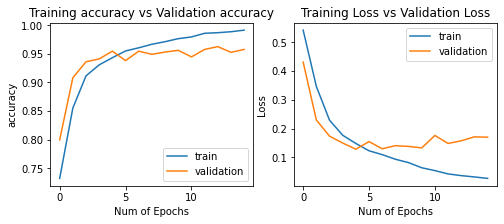

In [ ]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(history1.history['accuracy'])  
plt.plot(history1.history['val_accuracy'])  
plt.xlabel("Num of Epochs")  
plt.ylabel("accuracy")  
plt.title("Training accuracy vs Validation accuracy")  
plt.legend(['train','validation'])

plt.subplot(1,2,2) 
plt.plot(history1.history['loss'])  
plt.plot(history1.history['val_loss'])  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])
plt.savefig('accuracy1.jpg')

In [ ]:
x_test, y_test = generate_df(2, 'Male', 1000)

In [ ]:
#predicciones

model1_predictions = [np.argmax(model.predict(feature)) for feature in x_test ]

In [ ]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, precision_score, recall_score
print("accuracy: ", accuracy_score(y_test, model1_predictions))
print("precision: ", precision_score(y_test, model1_predictions, average = 'macro'))
print("recall: ", recall_score(y_test, model1_predictions, average = 'macro'))
print("f1: ", f1_score(y_test, model1_predictions, average = 'macro'))

accuracy:  0.946
precision:  0.9460285458269329
recall:  0.946
f1:  0.9459991359861757


In [ ]:
x2_train, y2_train = generate_df(0,'Eyeglasses', 10000)

In [ ]:
x2_val, y2_val = generate_df(1,'Eyeglasses',2000)

In [ ]:
x2_val.shape

(2000, 218, 178, 3)

In [ ]:
model2 = Sequential()
model2.add(Conv2D(32,kernel_size = 2,input_shape = (218, 178, 3),padding='same'))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Conv2D(32,kernel_size = 2,input_shape = (218, 178, 3), padding='same'))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Conv2D(64,kernel_size = 2,input_shape = (218, 178, 3), padding='same'))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Conv2D(64,kernel_size = 2,input_shape = (218, 178, 3), padding='same'))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))


model2.add(Flatten())
model2.add(Dense(units= 64,activation='sigmoid'))
model2.add(Dense(units= 64,activation='sigmoid'))
model2.add(Dense(units= 64,activation='sigmoid'))
model2.add(Dense(units = 2,activation = 'softmax'))
model2.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
history2 = model2.fit(x = x2_train , y = y2_train, batch_size = 50, epochs = 15, validation_data = (x2_val,y2_val))


Epoch 1/15
200/200 [==============================] - 9s 40ms/step - loss: 0.5010 - accuracy: 0.7376 - val_loss: 0.3216 - val_accuracy: 0.8745
Epoch 2/15
200/200 [==============================] - 7s 36ms/step - loss: 0.1710 - accuracy: 0.9387 - val_loss: 0.0964 - val_accuracy: 0.9700
Epoch 3/15
200/200 [==============================] - 7s 35ms/step - loss: 0.1094 - accuracy: 0.9631 - val_loss: 0.0849 - val_accuracy: 0.9740
Epoch 4/15
200/200 [==============================] - 7s 36ms/step - loss: 0.0798 - accuracy: 0.9737 - val_loss: 0.0825 - val_accuracy: 0.9740
Epoch 5/15
200/200 [==============================] - 7s 35ms/step - loss: 0.0680 - accuracy: 0.9791 - val_loss: 0.0915 - val_accuracy: 0.9710
Epoch 6/15
200/200 [==============================] - 7s 36ms/step - loss: 0.0592 - accuracy: 0.9804 - val_loss: 0.0813 - val_accuracy: 0.9745
Epoch 7/15
200/200 [==============================] - 7s 36ms/step - loss: 0.0511 - accuracy: 0.9836 - val_loss: 0.0840 - val_accuracy: 0.9735

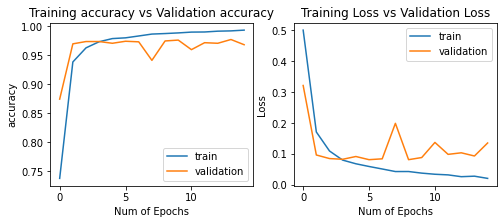

In [ ]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(history2.history['accuracy'])  
plt.plot(history2.history['val_accuracy'])  
plt.xlabel("Num of Epochs")  
plt.ylabel("accuracy")  
plt.title("Training accuracy vs Validation accuracy")  
plt.legend(['train','validation'])

plt.subplot(1,2,2) 
plt.plot(history2.history['loss'])  
plt.plot(history2.history['val_loss'])  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])
plt.savefig('accuracy2.jpg')

In [ ]:
x2_test, y2_test = generate_df(2, 'Eyeglasses', 1000)

In [ ]:
model2_predictions = [np.argmax(model2.predict(feature)) for feature in x2_test ]

In [ ]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, precision_score, recall_score
print("accuracy: ", accuracy_score(y2_test, model2_predictions))
print("precision: ", precision_score(y2_test, model2_predictions, average = 'macro'))
print("recall: ", recall_score(y2_test, model2_predictions, average = 'macro'))
print("f1: ", f1_score(y2_test, model2_predictions, average = 'macro'))

accuracy:  0.98
precision:  0.98
recall:  0.98
f1:  0.98


In [ ]:
x3_train, y3_train = generate_df(0,'Smiling', 10000)

In [ ]:
x3_val, y3_val = generate_df(1,'Smiling', 2000)

In [ ]:
model3 = Sequential()
model3.add(Conv2D(32,kernel_size = 2,input_shape = (218, 178, 3),padding='same'))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Conv2D(32,kernel_size = 2,input_shape = (218, 178, 3), padding='same'))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Conv2D(64,kernel_size = 2,input_shape = (218, 178, 3), padding='same'))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Conv2D(64,kernel_size = 2,input_shape = (218, 178, 3), padding='same'))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))


model3.add(Flatten())
model3.add(Dense(units= 64,activation='sigmoid'))
model3.add(Dense(units= 64,activation='sigmoid'))
model3.add(Dense(units= 64,activation='sigmoid'))
model3.add(Dense(units = 2,activation = 'softmax'))
model3.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
history3 = model3.fit(x = x3_train , y = y3_train, batch_size = 50, epochs = 15, validation_data = (x3_val,y3_val))

Epoch 1/15
200/200 [==============================] - 8s 38ms/step - loss: 0.6313 - accuracy: 0.6166 - val_loss: 0.4660 - val_accuracy: 0.7915
Epoch 2/15
200/200 [==============================] - 7s 35ms/step - loss: 0.3787 - accuracy: 0.8386 - val_loss: 0.3881 - val_accuracy: 0.8350
Epoch 3/15
200/200 [==============================] - 7s 35ms/step - loss: 0.2882 - accuracy: 0.8816 - val_loss: 0.2783 - val_accuracy: 0.8905
Epoch 4/15
200/200 [==============================] - 7s 35ms/step - loss: 0.2500 - accuracy: 0.8959 - val_loss: 0.2756 - val_accuracy: 0.8805
Epoch 5/15
200/200 [==============================] - 7s 35ms/step - loss: 0.2270 - accuracy: 0.9125 - val_loss: 0.2675 - val_accuracy: 0.8810
Epoch 6/15
200/200 [==============================] - 7s 36ms/step - loss: 0.2064 - accuracy: 0.9153 - val_loss: 0.2584 - val_accuracy: 0.8955
Epoch 7/15
200/200 [==============================] - 7s 36ms/step - loss: 0.1854 - accuracy: 0.9288 - val_loss: 0.2644 - val_accuracy: 0.8945

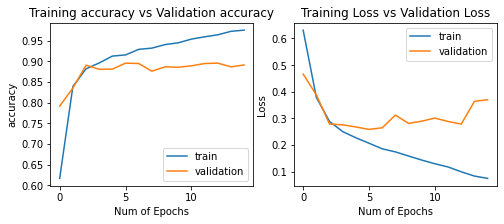

In [ ]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(history3.history['accuracy'])  
plt.plot(history3.history['val_accuracy'])  
plt.xlabel("Num of Epochs")  
plt.ylabel("accuracy")  
plt.title("Training accuracy vs Validation accuracy")  
plt.legend(['train','validation'])

plt.subplot(1,2,2) 
plt.plot(history3.history['loss'])  
plt.plot(history3.history['val_loss'])  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])
plt.savefig('accuracy3.jpg')

In [ ]:
x3_test, y3_test = generate_df(2, 'Smiling', 1000)

In [ ]:
model3_predictions = [np.argmax(model3.predict(feature)) for feature in x3_test ]

In [ ]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, precision_score, recall_score
print("accuracy: ", accuracy_score(y3_test, model3_predictions))
print("precision: ", precision_score(y3_test, model3_predictions, average = 'macro'))
print("recall: ", recall_score(y3_test, model3_predictions, average = 'macro'))
print("f1: ", f1_score(y3_test, model3_predictions, average = 'macro'))

accuracy:  0.883
precision:  0.8844779331751251
recall:  0.883
f1:  0.8828874548441052


In [ ]:
df_part = pd.read_csv('list_eval_partition.csv')
df_part[df_part['partition']==2].sample(10)

,image_id,partition
198748,198749.jpg,2
199450,199451.jpg,2
201444,201445.jpg,2
184379,184380.jpg,2
184439,184440.jpg,2
187325,187326.jpg,2
197197,197198.jpg,2
202334,202335.jpg,2
190699,190700.jpg,2
184694,184695.jpg,2


Male          0
Eyeglasses    0
Smiling       1
Name: 191831.jpg, dtype: int64

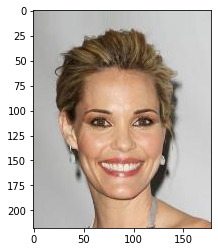

In [ ]:
ej = images_folder + '191831.jpg'
img = load_img(ej)
plt.grid(False)
plt.imshow(img)
atributes.loc[ej.split('/')[-1]][['Male','Eyeglasses','Smiling']]

La persona en la foto es Mujer 
La persona en la foto esta Sonriendo 
La persona en la foto esta Sin Lentes 


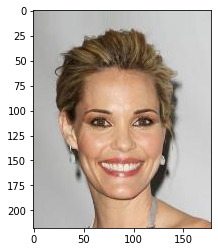

In [ ]:
ej = images_folder + '191831.jpg'
img = load_img(ej)
plt.grid(False)
plt.imshow(img)
atributes.loc[ej.split('/')[-1]][['Male','Eyeglasses','Smiling']]
img_array = img_to_array(img)
img_array = tensorflow.expand_dims(img_array, 0) # Create a batch
class_genre = ['Mujer', 'Hombre']
class_lentes = ['Sin Lentes', 'Con Lentes']
class_smile = ['No sonriendo', 'Sonriendo']
predictions1 = model.predict(img_array)
predictions2 = model2.predict(img_array)
predictions3 = model3.predict(img_array)
score1 = tensorflow.nn.softmax(predictions1[0])
score2 = tensorflow.nn.softmax(predictions2[0])
score3 = tensorflow.nn.softmax(predictions3[0])
print("La persona en la foto es {} ".format(class_genre[np.argmax(score1)]))
print("La persona en la foto esta {} ".format(class_smile[np.argmax(score3)]))
print("La persona en la foto esta {} ".format(class_lentes[np.argmax(score2)]))

In [ ]:
import itertools
def plot_confusion_matrix(cm,classes,normalize=False,title="Confusion_matrix",cmap=plt.cm.Blues):
  plt.imshow(cm,interpolation="nearest",cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks=np.arange(len(classes))
  plt.xticks(tick_marks,classes,rotation=45)
  plt.yticks(tick_marks,classes)

  if normalize:
    cm=cm.astype("float") / cm.sum(axis=1)[:,np.newaxis]
    cm = cm.round(decimals=4)
    print("Normalized confusion matrix")
  else:
    print("Confusion matrix,without normalization")
  print(cm)

  thresh = cm.max() /2.
  for i, j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
    plt.text(j,i,cm[i,j],
                    horizontalalignment="center",
                    color="white" if cm[i,j] > thresh else "black")
  plt.tight_layout()
  plt.ylabel("True label")
  plt.xlabel("Predicted label")
  plt.savefig("matrix.jpg")

Confusion matrix,without normalization
[[475  25]
 [ 29 471]]


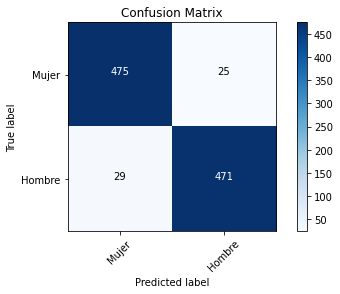

In [ ]:
#matriz de confusión 1

cm_plot_labels = ["Mujer","Hombre"]
cm = confusion_matrix(y_true=y_test,y_pred=model1_predictions)
plot_confusion_matrix(cm=cm,classes=cm_plot_labels,title="Confusion Matrix")
plt.savefig('confusion1.jpg')

Confusion matrix,without normalization
[[490  10]
 [ 10 490]]


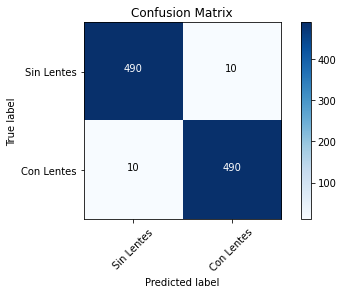

In [ ]:
#matriz de confusión 2

cm_plot_labels = ["Sin Lentes","Con Lentes"]
cm = confusion_matrix(y_true=y2_test,y_pred=model2_predictions)
plot_confusion_matrix(cm=cm,classes=cm_plot_labels,title="Confusion Matrix")
plt.savefig('confusion2.jpg')

Confusion matrix,without normalization
[[457  43]
 [ 74 426]]


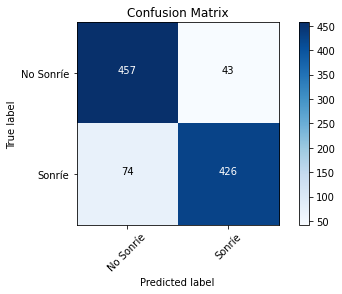

In [ ]:
#matriz de confusión 3

cm_plot_labels = ["No Sonríe","Sonríe"]
cm = confusion_matrix(y_true=y3_test,y_pred=model3_predictions)
plot_confusion_matrix(cm=cm,classes=cm_plot_labels,title="Confusion Matrix")
plt.savefig('confusion3.jpg')